# MNIST Digit Classification


This project focuses on classifying handwritten digits from the MNIST dataset using a Convolutional Neural Network (CNN). The project is structured to showcase a holistic approach to digit classification, combining effective data preprocessing, a well-designed architecture, and thoughtful evaluation methodologies.

### Environment Setup


In [1]:
import time as time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

## Data Understanding

**Load Dataset**

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

**Preview Dataset**

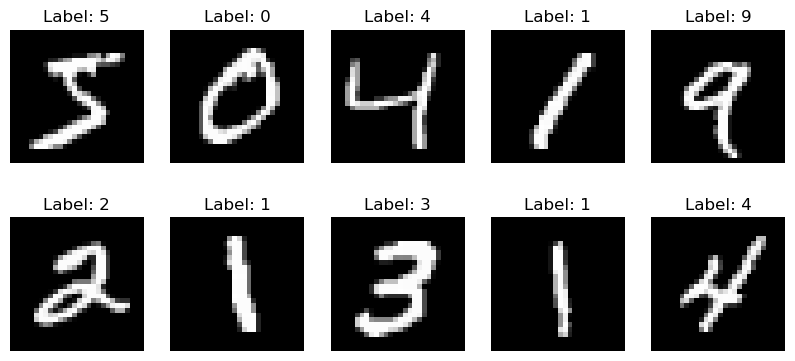

In [3]:
plt.figure(figsize=(10,6.5))
for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(X.iloc[i]).reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'Label: {y.iloc[i]}')
plt.subplots_adjust(hspace=-0.4)
plt.show()

**Digit Distribution**

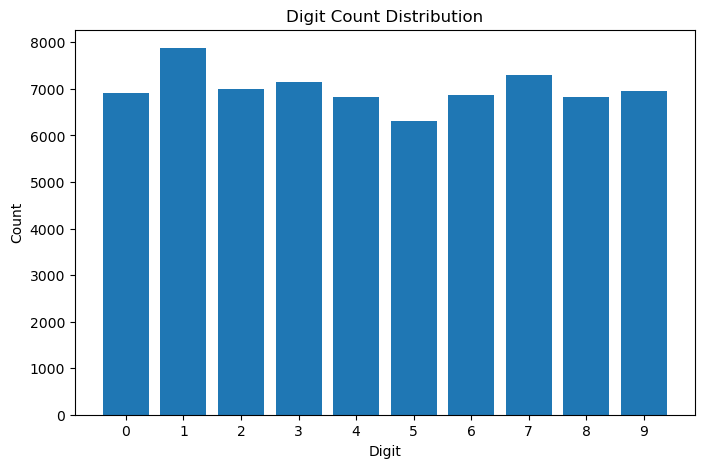

In [4]:
digit_counts = np.bincount(y)
digits = np.arange(10)
plt.figure(figsize=(8,5))
plt.bar(digits, digit_counts[:10])
plt.title('Digit Count Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(digits)
plt.show()

## Data Preprocessing

- Normalise pixel values to the 0-1 range.
- Reshape feature matrix X to dimensions (num_samples, 28, 28, 1).
- Encode labels using one-hot encoding.
- Apply data augmentation for increased model robustness. 
- Split the dataset into training and testing sets - 70% training, 30% testing.

In [5]:
X = X.values / 255
X = X.reshape(-1, 28, 28, 1)
y = to_categorical(y, num_classes = 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

**Augmented Images**

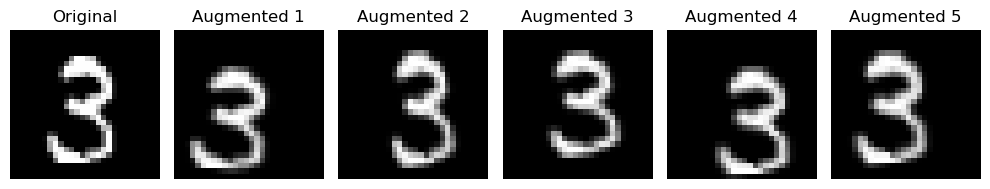

In [6]:
example_image = X_train[8] # digit 3
augmented_images = datagen.flow(np.expand_dims(example_image, axis=0), batch_size=5)

plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(example_image.reshape(28, 28), cmap='gray')
plt.title('Original')
plt.axis('off')
for i in range(5):
    augmented_image = augmented_images.next()[0].reshape(28, 28)
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f'Augmented {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Modeling

**CNN Architecture**

CNN model mimicks the architecture of VGG16. It comprises two convolutional blocks followed by max-pooling layers, a dense layer with dropout for regularisation and a softmax layer for classifying the 10 digit classes.

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                   

**Model Training**

In [8]:
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=50, 
                    validation_data=(X_test, y_test), callbacks=early_stopping, verbose=0)
end_time = time.time()
print(f'Elapsed Time {end_time-start_time:.2f}s')

Elapsed Time 395.48s


**Model Prediction**

In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

657/657 [==============================] - 4s 5ms/step


## Evaluation

**Classification Report**

In [10]:
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, digits=3))

Classification Report:
               precision    recall  f1-score   support

           0      0.999     0.994     0.996      2071
           1      0.997     0.997     0.997      2363
           2      0.994     0.997     0.996      2097
           3      0.998     0.994     0.996      2142
           4      0.995     0.994     0.994      2047
           5      0.993     0.994     0.993      1894
           6      0.993     0.997     0.995      2063
           7      0.995     0.993     0.994      2188
           8      0.996     0.993     0.994      2048
           9      0.989     0.995     0.992      2087

    accuracy                          0.995     21000
   macro avg      0.995     0.995     0.995     21000
weighted avg      0.995     0.995     0.995     21000



**Confusion Matrix**

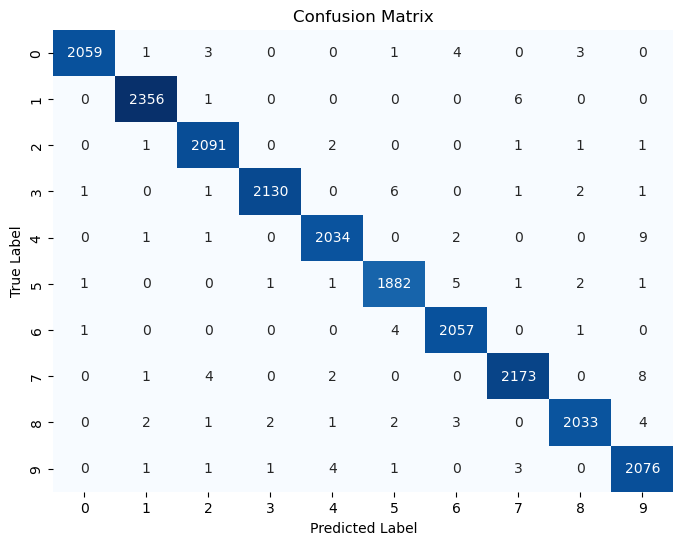

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Validation Loss**

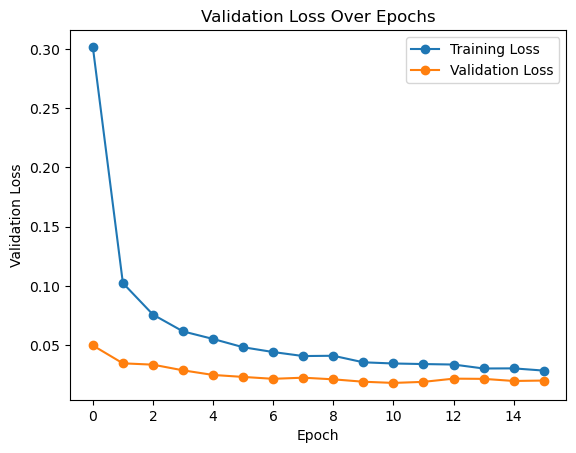

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

**Visualising Predictions**

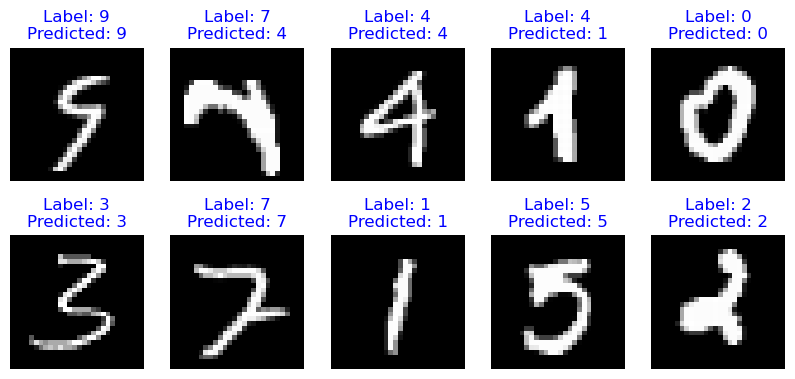

In [13]:
plt.figure(figsize=(10, 6.5))

for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(X_test[i]).reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Label: {y_test_classes[i]}\nPredicted: {y_pred_classes[i]}', color='blue')

plt.subplots_adjust(hspace=-0.4)
plt.show()

- Here we can see despite a potential mislabeling issue where the digit labeled as 4 might actually be 1, the model consistently makes accurate predictions for the digit 1. (1st Row, 4th Column)

## Conclusion

Model showcases exceptional performance of the model on MNIST digits, achieving an overall accuracy of 99.5%. Precision, recall, and F1-score metrics exceed 99% for each digit, highlighting the model's ability to accurately classify digits across the dataset. The macro and weighted averages further emphasises the consistent strong performance the model possess across all classes.

Model utilised early stopping, halting after the 14th epoch as the validation loss increased. Training and validation loss values shows a progressive decrease, followed by a slight increase, triggering early stopping to prevent overfitting.

In conclusion, the implemented Convolutional Neural Network (CNN) with a VGG16-like architecture emerges as a powerful and effective model for predicting handwritten digits in the MNIST dataset. The thorough data preprocessing, including normalisation and reshaping, lays a strong foundation for a robust model and is further enhanced through data augmentation techniques, contributing to its high accuracy and performance. Evaluation metrics such as precision, recall, and F1-score demonstrate the model's ability to accurately classify digits. Overall, the project showcases the successful creation of a reliable and proficient model for handwritten digit prediction.